# Imaging for OBC data redatuming

In [3]:
# env: UD_RM
import warnings
import os
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve
from subroutine.imaging import MarchenkoImaging
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

warnings.filterwarnings('ignore')
plt.close('all')

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

## Inputs

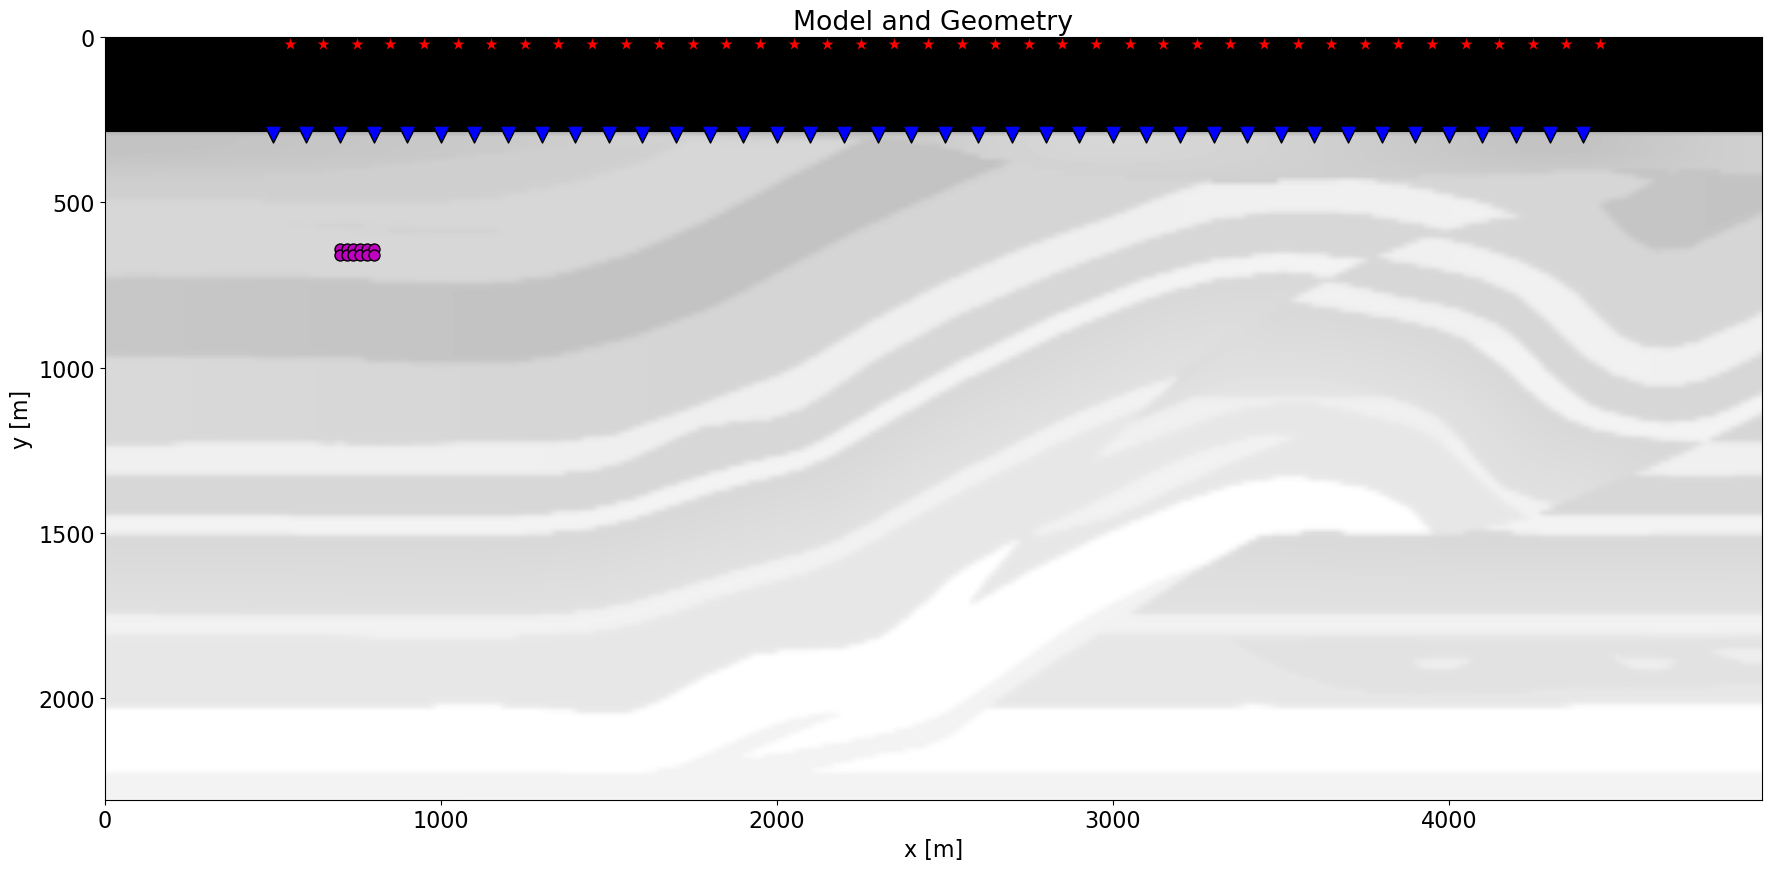

In [8]:
# Input parameters
inputfile = '/home/wangn0e/2022-2023/first_research/dataset/overthrust_RM15_pzsum.npz' 

tsoff = 0.05         # direct arrival time shift source side
troff = 0.05         # direct arrival time shift receiver side
nsmooth = 10         # time window smoothing
nfmax = 800          # max frequency for MDC (#samples)
niter = 10           # iterations
vel_s = 1500
convolvedata = True  # apply convolution to data
igaths = [21, 31,
          41, 51,
          61]        # indeces of angle gathers
nalpha = 41          # number of angles in Angle gathers
# igaths = [1, 2,
#          3]        # indeces of angle gathers
# nalpha = 2          # number of angles in Angle gathers

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Imaging domain
nvsx, nvsz = 126, 61
dvsx, dvsz = 24, 24
vsx = np.arange(nvsx)*dvsx + 1000
vsz = np.arange(nvsz)*dvsz + 510
# nvsx, nvsz = 6, 2
# dvsx, dvsz = 20, 20
# vsx = np.arange(nvsx)*dvsx + 700
# vsz = np.arange(nvsz)*dvsz + 640
VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

# Density model
rho = inputdata['rho']
vel = inputdata['vel']
z, x = inputdata['z'], inputdata['x']

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)

# Wavefield data 
Pu = inputdata['Puw'].transpose(1,0,2) #should be (r,s,t)
Pd = inputdata['Pd'].transpose(1,0,2)

# Convolve data with wavelet
if convolvedata:
    Pu = dt * np.apply_along_axis(convolve, -1, Pu, wav, mode='full')
    Pu = Pu[..., wav_c:][..., :nt]
    Pd = dt * np.apply_along_axis(convolve, -1, Pd, wav, mode='full')
    Pd = Pd[..., wav_c:][..., :nt]
else:
    Pu = dt * Pu
    Pd = dt * Pd
        

plt.figure(figsize=(18,9))
plt.imshow(vel, cmap='gray', extent=(x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.tight_layout()

(500.0, 4500.0, 3.297, 0.0)

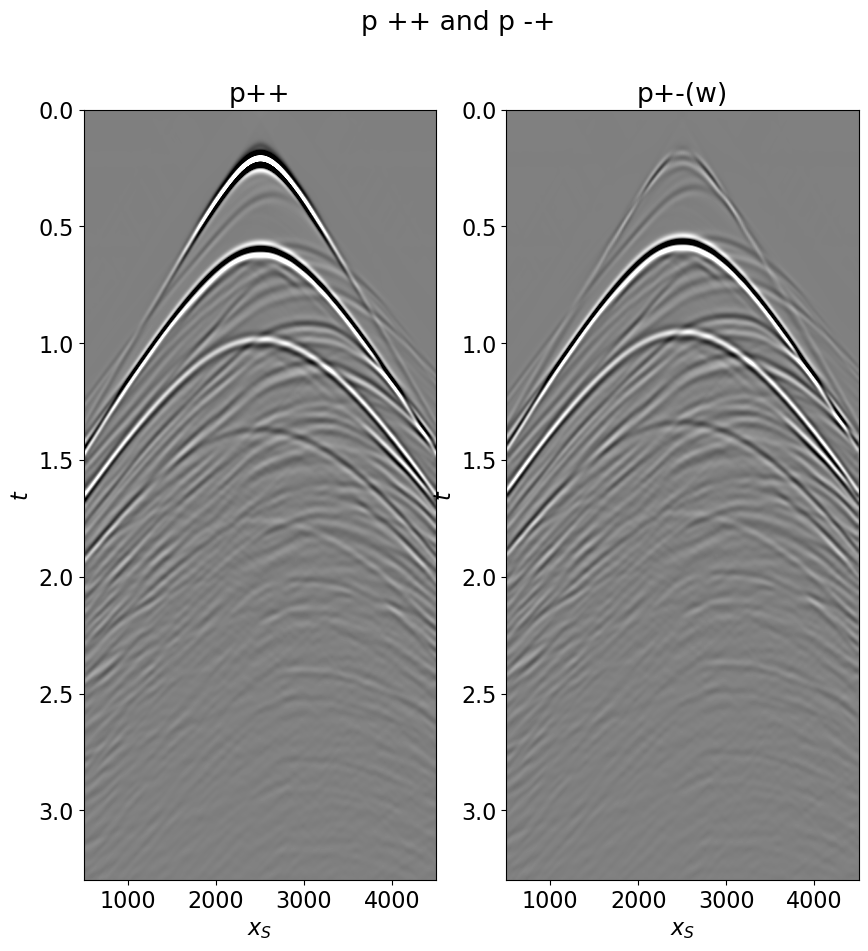

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('p ++ and p -+')
axs[0].imshow(Pd[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pu+Pd).max(), 
              vmax=0.1*np.abs(Pu+Pd).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[0].set_title('p++'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(Pu[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pu+Pd).max(), 
              vmax=0.1*np.abs(Pu+Pd).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[1].set_title('p+-(w)'), axs[1].set_xlabel(r'$x_S$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')

In [9]:
# para for picking positions of virtual sources (nvsx,nvsz) 
nx = x.size
nz = z.size
dx = x[1]-x[0]
dz = z[1]-z[0]
vsx_o = int((vsx[0]-x[0])/dx)
vsz_o = int((vsz[0]-z[0])/dz)
vsx_interval = int(dvsx/dx)
vsz_interval = int(dvsz/dz)
vsx_e = int(vsx[-1]/dx+1)
vsz_e = int(vsz[-1]/dz+1)

nx = x.size
nz = z.size
dx = x[1]-x[0]
dz = z[1]-z[0]

In [10]:
# vel, z ,r for computing direct arrival from vs to mirror receiver
dvel_flipud = int(np.ceil(np.max(r[1])/dz))
deltvel = np.flipud(vel[0:dvel_flipud])
vel_mr = np.vstack((deltvel, vel))

deltz = -np.flipud(z[0:dvel_flipud])-dz
z_mr = np.hstack((deltz, z))
nz_mr = z_mr.size

zr_mr = -r[1,:]
r_mr = np.vstack((r[0,:], zr_mr))

# direct arrival from vs to mirror receiver
trav_srcs_mr, trav_recs_mr, _, _, _, _ = Kirchhoff._traveltime_table(z_mr, x, s, r_mr, vel_mr.T, mode='eikonal')

trav_s_mr   = trav_srcs_mr.reshape(nx * nz_mr, ns) 
trav_s      = trav_s_mr.reshape(nx, nz_mr, ns) 
trav_s_arr  = trav_s[:,-nz:,:]

trav_r_mr   = trav_recs_mr.reshape(nx * nz_mr, nr) 
trav_mr     = trav_r_mr.reshape(nx, nz_mr, nr) 
trav_mr_arr = trav_mr[:,-nz:,:]

# para for picking virtual sources to sources and mirror receivers
trav_mr1 = trav_mr_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_mr2 = trav_mr1[::vsx_interval,::vsz_interval,:]

trav_s1 = trav_s_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_s2 = trav_s1[::vsx_interval,::vsz_interval,:]


In [12]:
nprocs = 2
iss, imck, ass, amck = \
    MarchenkoImaging(vsx, vsz, r, s, dr, ds, dt, nt, vel_s,tsoff, nsmooth, wav, wav_c,
                      nfmax, igaths, nalpha, 1,dict(Vzu=Pu, Vzd=Pd), kind='rmck_upd_vv',
                      niter=niter, nproc=nprocs, trav_s2=trav_s2, trav_mr2=trav_mr2)

nvsz =  2
ivsz =  0
ivsz =  1
Elapsed time (mins):  2.239901383717855


In [13]:
# display the images
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].imshow(iss, cmap='gray', vmin=-0.4*np.abs(iss).max(), vmax=0.4*np.abs(iss).max(), interpolation='sinc')
axs[0].axis('tight')
axs[1].imshow(imck, cmap='gray', vmin=-0.4*np.abs(imck).max(), vmax=0.4*np.abs(imck).max(), interpolation='sinc')
axs[1].axis('tight')
fig.tight_layout()

In [14]:
# angle gathers
ngath = len(igaths)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs[0].imshow(-ass.transpose(0, 2, 1).reshape(ngath * nalpha, nvsz).T,
              cmap='gray', vmin=-5e9, vmax=5e9,
              interpolation='sinc')
axs[0].axis('tight')
axs[0].set_title('Gathers RTM')
axs[1].imshow(amck.transpose(0, 2, 1).reshape(ngath * nalpha, nvsz).T,
              cmap='gray', vmin=-5e2, vmax=5e2,
              interpolation='sinc')
axs[1].set_title('Gathers Mck')
axs[1].axis('tight')
fig.tight_layout()